In [1]:
%cd ..
import os
import time

/data/apperception/apperception


In [2]:
from apperception.database import database
from apperception.world import empty_world
from apperception.utils import F
from apperception.predicate import camera, objects
from optimized_ingestion.utils.preprocess import preprocess
database.connection
from optimized_ingestion.cache import disable_cache
disable_cache()

/home/local/apperception/.installs/mambaforge/envs/apperception/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5 🚀 2022-11-23 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Using cache found in /data/apperception/apperception/weights/ultralytics_yolov5_master


Using cuda:0


YOLOv5 🚀 2022-11-30 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [3]:
NUSCENES_PROCESSED_DATA_FULL = "NUSCENES_PROCESSED_DATA_FULL"
if NUSCENES_PROCESSED_DATA_FULL in os.environ:
    DATA_DIR = os.environ[NUSCENES_PROCESSED_DATA_FULL]
else:
    DATA_DIR = "/data/apperception-data/processed/nuscenes/full-dataset-v1.0/Trainval"
NUSCENES_RAW_DATA_FULL = "NUSCENES_RAW_DATA_FULL"
if NUSCENES_RAW_DATA_FULL in os.environ:
    RAW_DATA_DIR = os.environ[NUSCENES_RAW_DATA_FULL]
else:
    RAW_DATA_DIR = "/work/apperception/data/raw/nuScenes/full-dataset-v1.0/Trainval"

In [4]:
import cv2
def construct_video(frames, size=(1600, 900), base=False, vid_name=None):
    unique_frames = []
    for f in frames:
        if f not in unique_frames:
            unique_frames.append(f)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vid_name = "./outputs/fig14_"+vid_name if vid_name else f"./outputs/{'fig14_base' if base else 'fig14_optimized'}.avi"
    display_video = cv2.VideoWriter(vid_name,fourcc, 1, size)
    for frame in unique_frames:
        img_path = os.path.join(RAW_DATA_DIR, frame)
        img = cv2.imread(img_path)
        display_video.write(img)

    display_video.release()

In [5]:
name = 'ScenicWorld' # world name
world = empty_world(name=name)

obj1 = objects[0]
cam = camera
world = world.filter(
    (F.like(obj1.type, 'car') | F.like(obj1.type, 'truck') | F.like(obj1.type, 'bus')) &
    (F.distance(cam.ego, obj1.trans@cam.timestamp) < 50) &
    (F.view_angle(obj1.trans@cam.time, cam.ego) < 70 / 2) &
    F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -180, -90) &
    F.contained(cam.ego, F.road_segment('road')) &
    F.contained(obj1.trans@cam.time, F.road_segment('road')) &
    F.angle_between(F.facing_relative(obj1.trans@cam.time, F.road_direction(obj1.traj@cam.time, cam.ego)), -15, 15) &
    (F.distance(cam.ego, obj1.trans@cam.time) < 10)
)

In [6]:
preprocess(world, DATA_DIR, ['scene-0769-CAM_FRONT'], base=False)

YOLOv5 🚀 2022-11-23 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Using cache found in /data/apperception/weights/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-30 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


scene-0769-CAM_FRONT --------------------------------------------------------------------------------
Stage:  DecodeFrame.ParallelDecodeFrame


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 15.65it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Detection2D.YoloDetection


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:02<00:00, 105.28it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Detection2D.ObjectTypeFilter
None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Detection3D.From2DAndRoad


239it [00:00, 3091.67it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  DetectionEstimation
ego_speed:  5.022388025656576


  0%|                                                                                                                                                    | 0/238 [00:00<?, ?it/s]TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersectio

  1%|█▊                                                                                                                                          | 3/238 [00:00<00:47,  4.90it/s]TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersection at or near point 1188.7054563623192 929.96953418158944
TopologyException: Input geom 1 is invalid: Self-intersection at 1188.7054563623192 929.96953418158944
Self-intersectio

Self-intersection at or near point 1229.4267255439472 978.45576936778275
TopologyException: Input geom 1 is invalid: Self-intersection at 1229.4267255439472 978.45576936778275
Self-intersection at or near point 1229.4267255439472 978.45576936778275
TopologyException: Input geom 1 is invalid: Self-intersection at 1229.4267255439472 978.45576936778275
Self-intersection at or near point 1229.4267255439472 978.45576936778275
TopologyException: Input geom 1 is invalid: Self-intersection at 1229.4267255439472 978.45576936778275
Self-intersection at or near point 1229.4267255439472 978.45576936778275
TopologyException: Input geom 1 is invalid: Self-intersection at 1229.4267255439472 978.45576936778275
Self-intersection at or near point 1229.4267255439472 978.45576936778275
 44%|████████████████████████████████████████████████████████████▎                                                                             | 104/238 [00:10<00:21,  6.36it/s]TopologyException: Input geom 1 is invalid: Se

number of skipped 5
{None: 234}
total_run_time 14.38673448562622
total_detection_time 11.29780912399292
total_generate_sample_plan_time 2.968441963195801
239
239
  filtered frames: 97.90794979079497%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKK...K.KKKKKKKKKKKKKKKKKKKKKKKKK.
Stage:  Tracking2D.StrongSORT
Successfully loaded pretrained weights from "/data/apperception/apperception/weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:14<00:00, 16.22it/s]


None
239
  filtered frames: 97.90794979079497%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKK...K.KKKKKKKKKKKKKKKKKKKKKKKKK.
Stage:  Tracking3D.From2DAndRoad


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 4012.37it/s]


None
239
  filtered frames: 97.90794979079497%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKK...K.KKKKKKKKKKKKKKKKKKKKKKKKK.
Stage:  SegmentTrajectory.FromTracking3D
None
239
  filtered frames: 97.90794979079497%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKK...K.KKKKKKKKKKKKKKKKKKKKKKKKK.
obj_id 1
obj_id 2
obj_id 3
obj_id 4
obj_id 5
obj_id 6
obj_id 7
obj_id 8
obj_id 9
obj_id 10
obj_id 11
obj_id 13
obj_id 14
obj_id 16
obj_id 21
obj_id 27
obj_id 28
obj_id 35
obj_id 37
obj_id 38
obj_id 40
obj_id 47
obj_id 49
obj_id 54
obj_id 55
obj_id 56
obj_id 57
obj_id 59
obj_id 44
obj_id 64
obj_id 66
obj_id 70
obj_id 81
obj_id 85
obj_id 91
obj_id 100
obj_id 101
obj_id 106
obj_id 

In [7]:
optimized_query_start = time.time()
id_time_camId_filename = world.get_id_time_camId_filename(1)
print(f'optimized query time: {time.time()-optimized_query_start}')

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT t0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as t0
        
        JOIN Cameras USING (cameraId)
        WHERE ((t0.objectType LIKE 'car' OR t0.objectType LIKE 'truck' OR t0.objectType LIKE 'bus') AND (ST_Distance(egoTranslation,valueAtTimestamp(t0.translations,timestamp))<50) AND (viewAngle(valueAtTimestamp(t0.translations,timestamp),egoHeading,egoTranslation)<35.0) AND angleBetween(facingRelative(egoHeading,roadDirection(egoTranslation,egoHeading)),-180,-90) AND contained(egoTranslation,roadSegment('road')) AND contained(valueAtTimestamp(t0.translations,timestamp),roadSegment('road')) AND angleBetween(facingRelative((headingAtTimestamp(t0.itemHeadings, timestamp))::real,roadDirection(valueAtTimestamp(t0.trajCentroids,timestamp),egoHeading)),-15,15) AND (ST_Distance(egoTranslation,valueAtTimestamp(t0.translations,times

In [8]:
id_time_camId_filename

[('scene-0769-CAM_FRONT_obj_100',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 862404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490862404.jpg'),
 ('scene-0769-CAM_FRONT_obj_100',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 912404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg'),
 ('scene-0769-CAM_FRONT_obj_118',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 912404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg'),
 ('scene-0769-CAM_FRONT_obj_100',
  datetime.datetime(2018, 8, 30, 12, 31, 31, 12404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491012404.jpg'),
 ('scene-0769-CAM_FRONT_obj_100',
  datetime.datetime(2018, 8, 30, 12, 31, 31, 11

In [9]:
optimized_results = [e[3] for e in id_time_camId_filename]
construct_video(optimized_results)

In [10]:
preprocess(world, DATA_DIR, ['scene-0769-CAM_FRONT'])


YOLOv5 🚀 2022-11-23 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Using cache found in /data/apperception/weights/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-30 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


scene-0769-CAM_FRONT --------------------------------------------------------------------------------
Stage:  DecodeFrame.ParallelDecodeFrame


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 17.24it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Detection2D.YoloDetection


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:02<00:00, 85.99it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Detection3D.From2DAndRoad


239it [00:00, 2992.00it/s]
YOLOv5 🚀 2022-11-23 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)



None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Tracking2D.StrongSORT
Successfully loaded pretrained weights from "/data/apperception/apperception/weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:15<00:00, 15.02it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  Tracking3D.From2DAndRoad


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 7021.35it/s]


None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
Stage:  SegmentTrajectory.FromTracking3D
None
239
  filtered frames: 100.0%
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
obj_id 1
obj_id 2
obj_id 3
obj_id 4
obj_id 5
obj_id 6
obj_id 7
obj_id 8
obj_id 9
obj_id 10
obj_id 11
obj_id 14
obj_id 17
obj_id 20
obj_id 22
obj_id 24
obj_id 27
obj_id 28
obj_id 30
obj_id 35
obj_id 36
obj_id 40
obj_id 46
obj_id 49
obj_id 52
obj_id 54
obj_id 64
obj_id 73
obj_id 75
obj_id 76
obj_id 77
obj_id 82
obj_id 83
obj_id 97
obj_id 104
obj_id 105
obj_id 106
obj_id 111
obj_id 120
obj_id 124
obj_id 1

In [11]:
base_query_start = time.time()
id_time_camId_filename_base = world.get_id_time_camId_filename(1)
print(f'base query time: {time.time()-base_query_start}')

execute: filter
execute: get_id_time_camId_filename
get_id_time_camId_filename 
        SELECT t0.itemId, cameras.timestamp, cameras.cameraId, cameras.filename
        FROM (SELECT * FROM item_general_trajectory) as t0
        
        JOIN Cameras USING (cameraId)
        WHERE ((t0.objectType LIKE 'car' OR t0.objectType LIKE 'truck' OR t0.objectType LIKE 'bus') AND (ST_Distance(egoTranslation,valueAtTimestamp(t0.translations,timestamp))<50) AND (viewAngle(valueAtTimestamp(t0.translations,timestamp),egoHeading,egoTranslation)<35.0) AND angleBetween(facingRelative(egoHeading,roadDirection(egoTranslation,egoHeading)),-180,-90) AND contained(egoTranslation,roadSegment('road')) AND contained(valueAtTimestamp(t0.translations,timestamp),roadSegment('road')) AND angleBetween(facingRelative((headingAtTimestamp(t0.itemHeadings, timestamp))::real,roadDirection(valueAtTimestamp(t0.trajCentroids,timestamp),egoHeading)),-15,15) AND (ST_Distance(egoTranslation,valueAtTimestamp(t0.translations,times

In [12]:
id_time_camId_filename_base

[('scene-0769-CAM_FRONT_obj_194',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 862404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490862404.jpg'),
 ('scene-0769-CAM_FRONT_obj_194',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 912404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg'),
 ('scene-0769-CAM_FRONT_obj_217',
  datetime.datetime(2018, 8, 30, 12, 31, 30, 912404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg'),
 ('scene-0769-CAM_FRONT_obj_194',
  datetime.datetime(2018, 8, 30, 12, 31, 31, 12404, tzinfo=datetime.timezone.utc),
  'scene-0769-CAM_FRONT',
  'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491012404.jpg'),
 ('scene-0769-CAM_FRONT_obj_194',
  datetime.datetime(2018, 8, 30, 12, 31, 31, 11

In [13]:
base_results = [e[3] for e in id_time_camId_filename_base]
construct_video(base_results, base=True)

In [14]:
base_results

['sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490862404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491112404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491412404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__15356574914124

In [15]:
false_negative = [f for f in base_results if f not in optimized_results]
print(len(false_negative))
construct_video(false_negative, vid_name="false_negative.avi")

0


In [16]:
false_positive = [f for f in optimized_results if f not in base_results]
print(len(false_positive))
construct_video(false_positive, vid_name="false_positive.avi")

0


In [1]:
investigation = [[217, 1205.0, 198.0, 391.0, 525.0], [104, 1198.0, 192.0, 390.0, 520.0]]

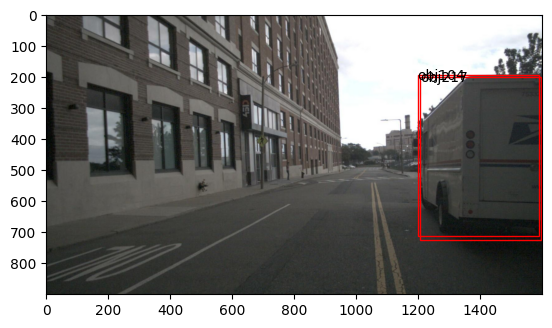

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('/work/apperception/data/raw/nuScenes/full-dataset-v1.0/Trainval/sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490862404.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for obj in investigation:
    obj_id = obj[0]
    x,y,w,h = obj[1:5]
    plt.text(x, y+15, 'obj'+str(obj_id))
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()